# A study on spontaneous decay rate of an atom in presence of a nanofiber using BEM approach

In these notes, I calculate the Local Density of States (LDOS), or the imaginary part of the on-site Green's function and hence the modified spontaneous emission rate of an atom in presence of a nanofiber using the Boundary Element Method (BEM). The BEM code is from Prof. Alejandro Manjavacas's group. 

This is an [IJulia notebook](https://github.com/JuliaLang/IJulia.jl), which provides a nice
browser-based [Jupyter](http://jupyter.org/) interface to the [Julia language](http://julialang.org/), a high-level dynamic language (similar to Matlab or Python+SciPy) for technical computing.  The notebook allows us to combine code and results in one place.

We are only manipulating the generated data from the simulation results in this notebook. As a brief recap of the simulation process, I have used a compiled BEM code by Alejandro's group written in C++ called `bem2D` on a cluster computing system. A configuration C++ code is defined in the file `scripts_ldos.cpp` which is in the same folder as `bem2D`. I compiled the script and put the generated executable into another folder called `p21`, for example, by
```
g++ scripts_ldos.cpp -lstdc++ -o ../p21/scripts_ldos
```
Then ran the executable and submitted the generated PBS script to the cluster system to run the simulation:
```
cd ../p21/
./scripts_ldos
qsub ldos_N_1_lam_894_eps_4_0_a_225_x_405_y_0_q_0_1.45_146.pbs
```
Notice that the name of the PBS script is automatically generated based on the configuration parameters for this simulation. The name will vary for different simulations. After running the script, I got a set of data files--one has the same name as the PBS script but with a `.dat` extension for the data table storing the calculated LDOS values; there are another two `*.dat` files for the geometry of boundary and dieletric function distribution. We will look into those data files in the following sections.


## 3D dielectric waveguide simulated in 2D

Just a little more detail on the simulation itself: By assuming the waveguide along z-axis or the light propagation direction is uniform, one can completely solve the boundary condition problem of dipole emission by simulating the field in one single layer of the xy cross section. The z-component of the field only adds in a phase factor. The data of the simulated result is stored in the /data/ folder of this repo. 

We can read in this data as a matrix of numbers by the `readdlm` function in Julia with the `header=false` option meaning that it reads the first line as the beginning of the data entries without a list of strings describing each column.

Now, let's plot the results.  I'll use the [PyPlot](https://github.com/stevengj/PyPlot.jl) package in Julia, which is an interface to the sophisticated [matplotlib](http://matplotlib.org/) Python plotting library.   We'll plot three things:

* The waveguide structure in terms of $\epsilon$ and the interface boundary between two media.
* Plot the LDOS components for a fixed dipole position.
* Calculate the waveguide-modified spontaneous decay rate when the dipole varies its position outside of the waveguide.



### Plotting the boundary and index of refraction profile of the waveguide in the xy cross section

Our boundary points are meshed in the files `/data/geom_a_225.data` and `/data/geom_regions_a_225.data`, which positions where the equivalent charges and current sources to be computed in the BEM simulation. The waveguide has a circular cross-section of a radius $a=225nm$ ($nm$ is the unit of length) and a index of refraction of $n_1=n_{core}=1.4496$ for the waveguide material and $n_2=n_{clad}=1$ for the vacuum clad. 

It is good to plot out the mesh of index of refraction in space and find out how good is the mesh resolution. This can be done by plotting out the output eps file in a simple data table format, which ends in `.dat`. 

The following will first print out some of the data in order to figure out the physics meaning of the dimensions. They should contain the coordinate and index of refraction information for the simulation.

In [1]:
boundary = readdlm("data/geom_regions_a_225.dat", header=false);
boundarypoints = boundary[:,1:3]

10201×3 Array{Float64,2}:
 -269.999  -269.998  1.0
 -269.999  -264.599  1.0
 -269.999  -259.199  1.0
 -269.999  -253.799  1.0
 -269.999  -248.399  1.0
 -269.999  -242.999  1.0
 -269.999  -237.599  1.0
 -269.999  -232.199  1.0
 -269.999  -226.799  1.0
 -269.999  -221.399  1.0
 -269.999  -215.999  1.0
 -269.999  -210.599  1.0
 -269.999  -205.199  1.0
    ⋮                   
  269.994   210.599  1.0
  269.994   215.999  1.0
  269.994   221.399  1.0
  269.994   226.799  1.0
  269.994   232.199  1.0
  269.994   237.599  1.0
  269.994   242.999  1.0
  269.994   248.399  1.0
  269.994   253.799  1.0
  269.994   259.199  1.0
  269.994   264.599  1.0
  269.994   269.998  1.0

In [2]:
epsilon3D = readdlm("data/geom_a_225.dat", header=false);
epsilon2Dpoints = epsilon3D[:,[1,2,4]]

471×3 Array{Float64,2}:
 224.995    1.50075  1.0
 224.955    4.50198  1.0
 224.875    7.50241  1.0
 224.755   10.5015   1.0
 224.595   13.4987   1.0
 224.395   16.4936   1.0
 224.155   19.4855   1.0
 223.875   22.4739   1.0
 223.555   25.4583   1.0
 223.196   28.4382   1.0
 222.796   31.413    1.0
 222.358   34.3823   1.0
 221.879   37.3454   1.0
   ⋮                    
 222.358  -34.3823   1.0
 222.796  -31.413    1.0
 223.196  -28.4382   1.0
 223.555  -25.4583   1.0
 223.875  -22.4739   1.0
 224.155  -19.4855   1.0
 224.395  -16.4936   1.0
 224.595  -13.4987   1.0
 224.755  -10.5015   1.0
 224.875   -7.50241  1.0
 224.955   -4.50198  1.0
 224.995   -1.50075  1.0

Now we plot out the data in a 2D (xy) plane. 

269.999

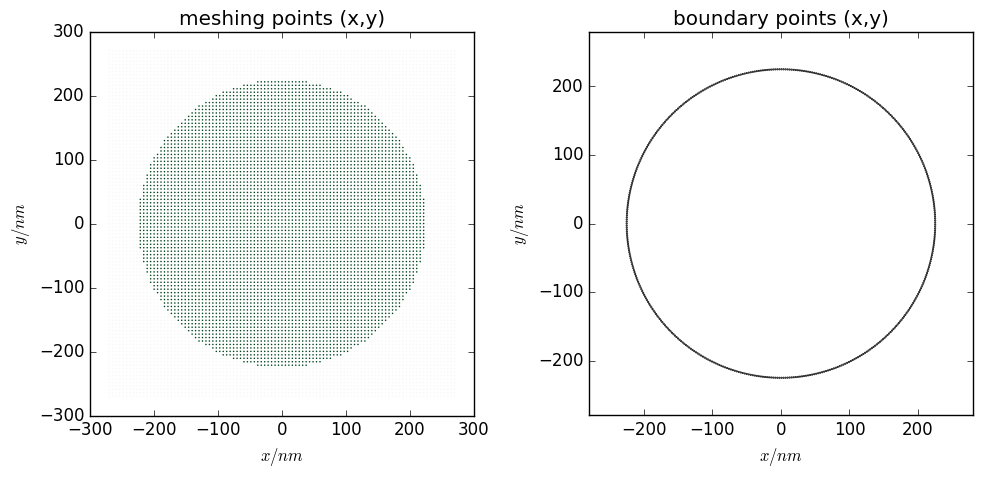

In [3]:
using PyPlot
#println(convert(Int64,floor(lenz/2)))
x = boundarypoints[:,1];
y = boundarypoints[:,2];
v_regions = boundarypoints[:,3];
lenx = length(x)

fig = figure("Boundary points plot",figsize=(10,10))
ax = fig[:add_subplot](1,2,1)
c = get_cmap("PRGn")
rgbs = [c(norm(value/2.)) for value in v_regions]
scatter(x,y,c=rgbs,linewidths=0,marker=".",s=5)

xlabel(L"x/nm")
ylabel(L"y/nm")
axis("image")
xlim(-300,300)
ylim(-300,300)
tight_layout()
title("meshing points (x,y)");
display(maximum(abs.(x)))

subplot(1,2,2)
x_eps = epsilon2Dpoints[:,1]; y_eps = epsilon2Dpoints[:,2]; v_eps = epsilon2Dpoints[:,3];
ax = fig[:add_subplot](1,2,2)
c = get_cmap("Greys")
rgbs = [c(norm(value/2.)) for value in v_eps]
scatter(x_eps,y_eps,c=rgbs, marker = :.,s=1)

xlabel(L"x/ nm")
ylabel(L"y/ nm")
axis("image")
xlim(-280,280)
ylim(-280,280)
tight_layout()
#gcf() # Needed for IJulia to plot inline
title("boundary points (x,y)");

The first plot only shows the 101$\times$101 data points, in which the plotted area is the computing region of a $270nm\times 270nm$ square with the nanofiber region colored in green. The figure on the right covers the boundary points pretty densely, although the point overlap at the $(225,0)nm$ location is not visible.


# Plotting the LDOS components with a fixed dipole position

To calculate the modified decay rates, we need to use the LDOS value at the dipole position. The result is calculated at a series of $k$ points. I expect to see a continuous positive curve when $k\in [0,1]\omega/c$ or in the radiative mode regime and a single positive spark in the $[1,1.45]\omega/c$ or guided mode regime--given the waveguide is a single-mode glass fiber.

1.0589

1.0589

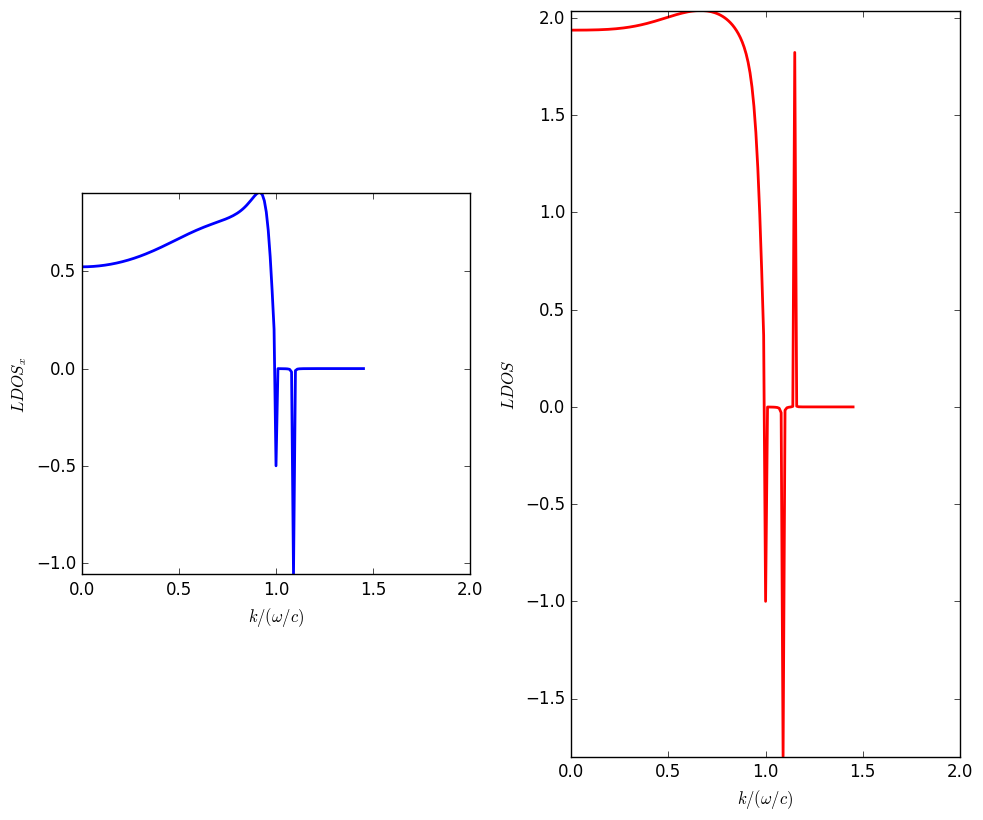

In [4]:
ldos = readdlm("data/ldos_N_1_lam_894_eps_2.1013_0_a_225_x_405_y_0_q_0_1.45_146.dat", header=false);
ldosqpoints = ldos[:,[2,5,6,7,8]]
using PyPlot
#println(convert(Int64,floor(lenz/2)))
q = ldosqpoints[:,1]
ldosx = ldosqpoints[:,2]
ldosy = ldosqpoints[:,3]
ldosz = ldosqpoints[:,4]
ldos_av = ldosqpoints[:,5]
lenx = length(q)

fig = figure("LDOS q plot",figsize=(10,10))
ax = fig[:add_subplot](1,2,1)
cp = ax[:plot](q, ldosx, "b-", linewidth=2.0)
#ax[:clabel](cp, inline=1, fontsize=5)

xlabel(L"k/(\omega/c)")
ylabel(L"LDOS_x")
axis("image")
xlim(-0.0,2)
#ylim(-300,300)
tight_layout()
gcf() # Needed for IJulia to plot inline
display(maximum(abs.(ldosx)))

ax = fig[:add_subplot](1,2,2)
cp = ax[:plot](q, ldos_av, "r-", linewidth=2.0)
#ax[:clabel](cp, inline=1, fontsize=5)

xlabel(L"k/(\omega/c)")
ylabel(L"LDOS")
axis("image")
xlim(-0.0,2)
#ylim(-300,300)
tight_layout()
gcf() # Needed for IJulia to plot inline
display(maximum(abs.(ldosx)))

As you can see, ***there are negative sparks in the guided mode regime***. It could be a numerical error in the code and may be removed using some tricks.

Now we can integrate the $\mathrm{LDOS}_i$ values over $k$ along the whole axis to obtain the total decay rate or from $0$ to $\omega/c$ to obtain the radiative mode contribution for the decay rate. Each integral can be performed as a sum over all discrete points along the $k$-axis using the Trapezoid approximation as below:
$$\begin{align}\int \mathrm{LDOS}_i(k)dk &= \sum_{j=1,\cdots,N-1} \frac{\mathrm{LDOS}_i(k_j)+\mathrm{LDOS}_i(k_j+1)}{2}\Delta k\\
&= \left(\frac{\mathrm{LDOS}_i(k_N)+\mathrm{LDOS}_i(k_N)}{2}+\sum_{j=2,\cdots,N-1}\mathrm{LDOS}_i(k_j)\right)\Delta k,\end{align}$$
where $N$ is the total number of data points along the $k$-axis, and $\Delta k=k_j-k_{j-1}=k_2-k_1$ as the interval of $k$-vector in a uniform distribution manner.

In our case, the integrand is discontinuous and breaks the continuity at $k=k_0=\omega/c$ point. Therefore, we divide our integration limit into the $[0,n_2)k_0$ and $(n_2,n_1]k_0$ two regions corresponding to radiation mode contribution and guided mode contribution parts, where $n_2=1$ is the index of refraction of the vacuum clad and $n_1=1.4496$ is the index of refraction of the waveguide bulk material. Since there are surdden jumps in the guided mode regime, the integration may have some error using current method, but it shouldn't be too large as the jumps are in small intervals.

In [5]:
length_of_q=length(ldosqpoints[:,1])
breakpoint = Int(floor((length_of_q-1)/maximum(ldosqpoints[:,1])*1.)) # The breaking point of index is chosen under the fact that the radiation contribution part takes a half space for $n_1=2$.
using NumericalIntegration
ldos_x_rad = integrate(ldosqpoints[1:breakpoint,1],ldosqpoints[1:breakpoint,2])
ldos_x_guide = integrate(ldosqpoints[breakpoint:end,1],ldosqpoints[breakpoint:end,2])
ldos_x = ldos_x_rad+ldos_x_guide;
ldos_y_rad = integrate(ldosqpoints[1:breakpoint,1],ldosqpoints[1:breakpoint,3])
ldos_y_guide = integrate(ldosqpoints[breakpoint:end,1],ldosqpoints[breakpoint:end,3])
ldos_y = ldos_y_rad+ldos_y_guide;
ldos_z_rad = integrate(ldosqpoints[1:breakpoint,1],ldosqpoints[1:breakpoint,4])
ldos_z_guide = integrate(ldosqpoints[breakpoint:end,1],ldosqpoints[breakpoint:end,4])
ldos_z = ldos_z_rad+ldos_z_guide;
ldos_rad = integrate(ldosqpoints[1:breakpoint,1],ldosqpoints[1:breakpoint,5])
ldos_guide = integrate(ldosqpoints[breakpoint:end,1],ldosqpoints[breakpoint:end,5])
ldos_total = ldos_rad + ldos_guide;
# Print out the result.
@printf("\Delta k = %4f k_0.\n",ldosqpoints[2,1]-ldosqpoints[1,1])
@printf("LDOS_x_rad=%5f, LDOS_x_guide=%5f, LDOS_x=%5f;\n",ldos_x_rad,ldos_x_guide,ldos_x)
@printf("LDOS_y_rad=%5f, LDOS_y_guide=%5f, LDOS_y=%5f;\n",ldos_y_rad,ldos_y_guide,ldos_y)
@printf("LDOS_z_rad=%5f, LDOS_z_guide=%5f, LDOS_z=%5f;\n",ldos_z_rad,ldos_z_guide,ldos_z)
@printf("LDOS_rad = %5f, LDOS_guide = %5f, LDOS = %5f.",ldos_rad,ldos_guide,ldos_total)

Delta k = 0.010000 k_0.


Notice that the result above was calculated using a $k$-resolution of $\Delta k= 0.01k_0$. We can compare the results above with a coarser/finer gridding cases.

# LDOS with material losses
The above shows the misbehavior of the guided mode contribution to LDOS. The peaks are due to numerical difficulties when the width of peaks are too narrow where the width of peaks are determined by the loss rate of the material according to uncertainty principle. 

Below we will study the cases with material losses. 

1.0589

1.0589

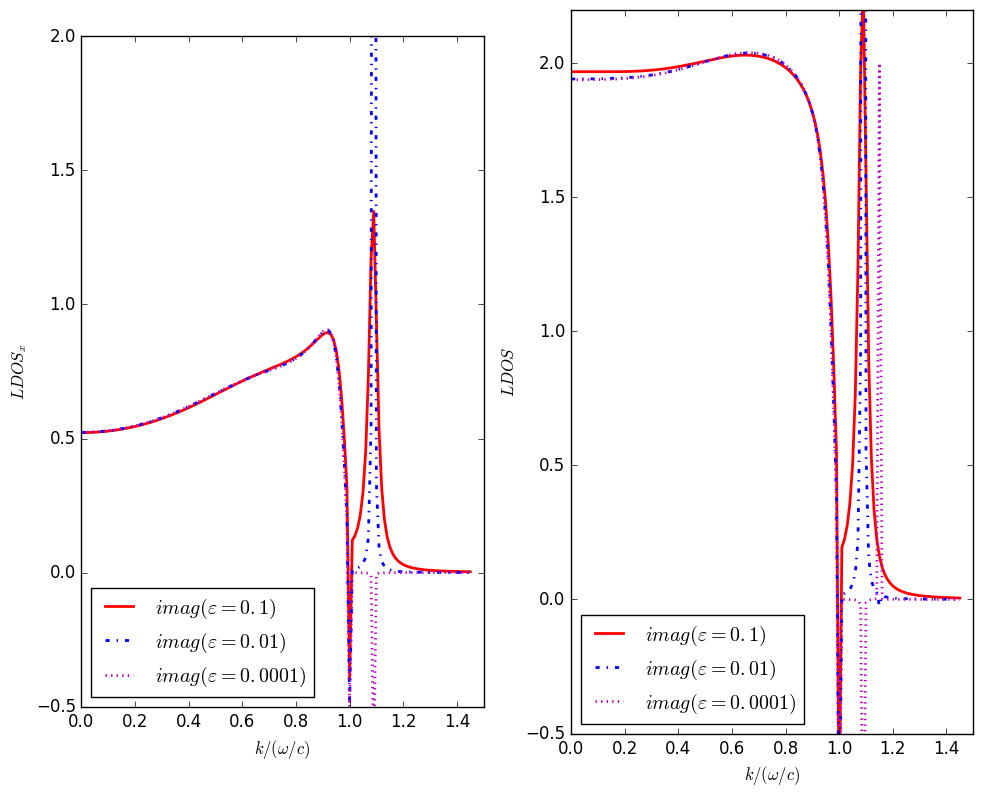

In [6]:
ldos_1 = readdlm("data/ldos_N_1_lam_894_eps_2.1013_0.1_a_225_x_405_y_0_q_0_1.45_146.dat", header=false);
ldosqpoints_1 = ldos_1[:,[2,5,6,7,8]]
ldos_01 = readdlm("data/ldos_N_1_lam_894_eps_2.1013_0.01_a_225_x_405_y_0_q_0_1.45_146.dat", header=false);
ldosqpoints_01 = ldos_01[:,[2,5,6,7,8]]
ldos_0001 = readdlm("data/ldos_N_1_lam_894_eps_2.1013_0.0001_a_225_x_405_y_0_q_0_1.45_146.dat", header=false);
ldosqpoints_0001 = ldos_0001[:,[2,5,6,7,8]]
using PyPlot
#println(convert(Int64,floor(lenz/2)))
q = ldosqpoints_1[:,1]
lenx = length(q)
ldosx_1 = ldosqpoints_1[:,2]
ldosy_1 = ldosqpoints_1[:,3]
ldosz_1 = ldosqpoints_1[:,4]
ldos_av_1 = ldosqpoints_1[:,5]
ldosx_01 = ldosqpoints_01[:,2]
ldosy_01 = ldosqpoints_01[:,3]
ldosz_01 = ldosqpoints_01[:,4]
ldos_av_01 = ldosqpoints_01[:,5]
ldosx_0001 = ldosqpoints_0001[:,2]
ldosy_0001 = ldosqpoints_0001[:,3]
ldosz_0001 = ldosqpoints_0001[:,4]
ldos_av_0001 = ldosqpoints_0001[:,5]


fig = figure("LDOS q plot",figsize=(10,10))
ax = fig[:add_subplot](1,2,1)
cp = ax[:plot](q, ldosx_1, "r-", linewidth=2.0)
cp = ax[:plot](q, ldosx_01, "b-.", linewidth=2.0)
cp = ax[:plot](q, ldosx_0001, "m:", linewidth=2.0)
#ax[:clabel](cp, inline=1, fontsize=5)

xlabel(L"k/(\omega/c)")
ylabel(L"LDOS_x")
axis("image")
xlim(-0.0,1.5)
ylim(-0.5,2)
tight_layout()
gcf() # Needed for IJulia to plot inline
legend([L"imag(\varepsilon=0.1)",L"imag(\varepsilon=0.01)",L"imag(\varepsilon=0.0001)"],loc="lower left")
display(maximum(abs.(ldosx)))

ax = fig[:add_subplot](1,2,2)
cp = ax[:plot](q, ldos_av_1, "r-", linewidth=2.0)
cp = ax[:plot](q, ldos_av_01, "b-.", linewidth=2.0)
cp = ax[:plot](q, ldos_av_0001, "m:", linewidth=2.0)
#ax[:clabel](cp, inline=1, fontsize=5)

xlabel(L"k/(\omega/c)")
ylabel(L"LDOS")
axis("image")
xlim(-0.0,1.5)
ylim(-0.5,2.2)
tight_layout()
gcf() # Needed for IJulia to plot inline
legend([L"imag(\varepsilon=0.1)",L"imag(\varepsilon=0.01)",L"imag(\varepsilon=0.0001)"],loc="lower left")
display(maximum(abs.(ldosx)))

## LDOS components as a function of dipole position

We can also plot out the LDOS's when the dipole is placed at different locations along the x-axis. Here we are using some rough parameters just for demonstration purpose.

As plotted below, the dipole is changing position from $270$nm to $572.5$nm from the origin (center of the waveguide cross section) along the x-axis. 

In [7]:
# Load the simulated data.
ldos = readdlm("data/ldos_N_1_lam_894_eps_2.1013_0_a_225_x0_270_x1_572.5_nx_14_y_0_q_0_1.45_146.dat", header=false);

In [8]:
ldosqpoints = ldos[:,[2,3,5,6,7,8]]
lenr = 14; rstart=270.; rend=572.5; 
lenq = 146; 
breakpoint = Int(floor((lenq-1)/maximum(ldosqpoints[:,1])*1.)) # The breaking point of index is chosen under the fact that the radiation contribution part takes a 1.0/max(k) space for $n_1=1.45$.
rprime = linspace(rstart,rend,lenr);
drprime = rprime[2]-rprime[1]; # Gradient of atom position vector.
ldos_rscan = zeros(lenq,5,lenr);
ldos_int = zeros(lenr,12);
ii=1;
using NumericalIntegration
for ri in rprime
    ind=find(abs.(ldosqpoints[:,2].-ri).<drprime/2.);
    ldos_rscan[:,:,ii]=ldosqpoints[ind,[1,3,4,5,6]];
    
    ldos_x_rad = integrate(ldos_rscan[1:breakpoint,1,ii],ldos_rscan[1:breakpoint,2,ii])
    ldos_x_guide = integrate(ldos_rscan[breakpoint:end,1,ii],ldos_rscan[breakpoint:end,2,ii])
    ldos_x = ldos_x_rad+ldos_x_guide;
    ldos_y_rad = integrate(ldos_rscan[1:breakpoint,1,ii],ldos_rscan[1:breakpoint,3,ii])
    ldos_y_guide = integrate(ldos_rscan[breakpoint:end,1,ii],ldos_rscan[breakpoint:end,3,ii])
    ldos_y = ldos_y_rad+ldos_y_guide;
    ldos_z_rad = integrate(ldos_rscan[1:breakpoint,1,ii],ldos_rscan[1:breakpoint,4,ii])
    ldos_z_guide = integrate(ldos_rscan[breakpoint:end,1,ii],ldos_rscan[breakpoint:end,4,ii])
    ldos_z = ldos_z_rad+ldos_z_guide;
    ldos_rad = integrate(ldos_rscan[1:breakpoint,1,ii],ldos_rscan[1:breakpoint,5,ii])
    ldos_guide = integrate(ldos_rscan[breakpoint:end,1,ii],ldos_rscan[breakpoint:end,5,ii])
    ldos_total = ldos_rad + ldos_guide;
    
    ldos_int[ii,1]=ldos_x_rad;
    ldos_int[ii,2]=ldos_x_guide;
    ldos_int[ii,3]=ldos_x;
    ldos_int[ii,4]=ldos_y_rad;
    ldos_int[ii,5]=ldos_y_guide;
    ldos_int[ii,6]=ldos_y;
    ldos_int[ii,7]=ldos_z_rad;
    ldos_int[ii,8]=ldos_z_guide;
    ldos_int[ii,9]=ldos_z;
    ldos_int[ii,10]=ldos_rad;
    ldos_int[ii,11]=ldos_guide;
    ldos_int[ii,12]=ldos_total;
    ii+=1;
end

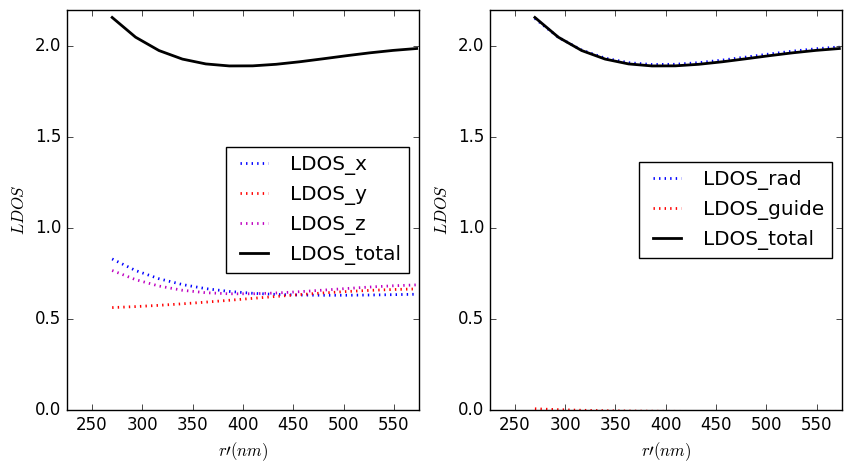

PyObject <matplotlib.legend.Legend object at 0x7fc8f21e5450>

In [9]:
# Plot the LDOS's.
using PyPlot
fig = figure("LDOS(r') plot",figsize=(10,5))
ax = fig[:add_subplot](1,2,1)
cp = ax[:plot](rprime, ldos_int[:,3], "b:", linewidth=2.0)
cp = ax[:plot](rprime, ldos_int[:,6], "r:", linewidth=2.0)
cp = ax[:plot](rprime, ldos_int[:,9], "m:", linewidth=2.0)
cp = ax[:plot](rprime, ldos_int[:,12], "k-", linewidth=2.0)

xlabel(L"r\prime(nm)")
ylabel(L"LDOS")
ylim(-0.0,2.2)
xlim(225,575)
legend(["LDOS_x","LDOS_y","LDOS_z","LDOS_total"],loc="right")

ax = fig[:add_subplot](1,2,2)
cp = ax[:plot](rprime, ldos_int[:,10], "b:", linewidth=2.0)
cp = ax[:plot](rprime, ldos_int[:,11], "r:", linewidth=2.0)
cp = ax[:plot](rprime, ldos_int[:,12], "k-", linewidth=2.0)

xlabel(L"r\prime(nm)")
ylabel(L"LDOS")
ylim(-0.0,2.2)
xlim(225,575)
legend(["LDOS_rad","LDOS_guide","LDOS_total"],loc="right")

The LDOS values seem larger than what I expected given $n_1=1.4496$..

## Improved method to calculate the relative decay rates

Now, we consider to only use the radiation part of LDOS from the BEM calculation while using the analytical solution of the Green's function tensor for the guided mode contribution part of the decay rate calculation.
To verify this idea, here we compare the radiation contribution part of the averaged decay rate (or when the dipole is orientated along $[1,1,1]$ direction) against our trusted results calculated from the known analytical solution on Matlab.

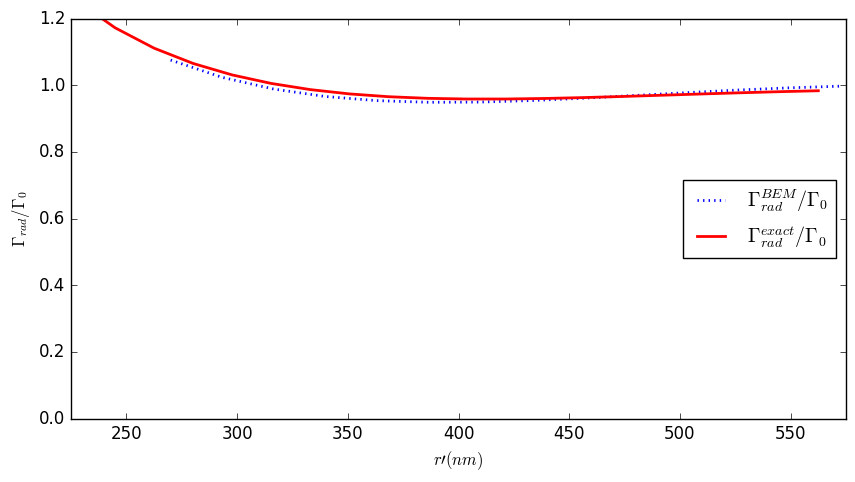

PyObject <matplotlib.legend.Legend object at 0x7fc8f104d190>

In [10]:
# Read data from the matlab calculation for the exact solution of un-guided mode contribution part for the averaged decay rate.
using MAT
matfile = matopen("data/nanofiber_decay_data.mat")
rp0_test=read(matfile,"rp0_test");
gamma_rad = read(matfile,"gamma_rad");
close(matfile)
# Plot both BEM and exact solution of the un-guided mode contribution to the averaged decay rate as a function of dipole position.
using PyPlot
fig = figure(L"\Gamma_{rad}/\Gamma_0(r') plot",figsize=(10,5))
ax = fig[:add_subplot](1,1,1)
cp = ax[:plot](rprime, ldos_int[:,10]/2.0, "b:", linewidth=2.0)
cp = ax[:plot](rp0_test[1,:]/1.e-9, 1+sum(gamma_rad,2), "r-", linewidth=2.0)

xlabel(L"r\prime(nm)")
ylabel(L"\Gamma_{rad}/\Gamma_0")
ylim(0.0,1.2)
xlim(225,575)
legend([L"\Gamma_{rad}^{BEM}/\Gamma_0",L"\Gamma_{rad}^{exact}/\Gamma_0"],loc="right")

The result above shows a good agreement between the BEM method and the exact solution for the radiation mode contribution to the decay rate. 
The mismatch becomes considerable only when the dipole is very close to the surface, in which case there is a negative LDOS on the edge of the BEM calculation in the $k$-space. 
This small error may be corrected by filtering out the negative LDOS values in the $k$-space.

With the known Green's function tensor expression for the guided modes, one can hence obtain a precise enough result for the decay rates as a function of dipole orientation and atom position.

# Calculation of Green's function tensor using BEM

BEM can output full local field components so that computing the radiative mode contribution to the full Green's function tensor is possible. With the Green's function tensor, one can then calculate the modified decay rates with dipoles orientated along arbitrary directions--including the dipole transitions corresponding to $\sigma_\pm$ and $\pi$ transitions.

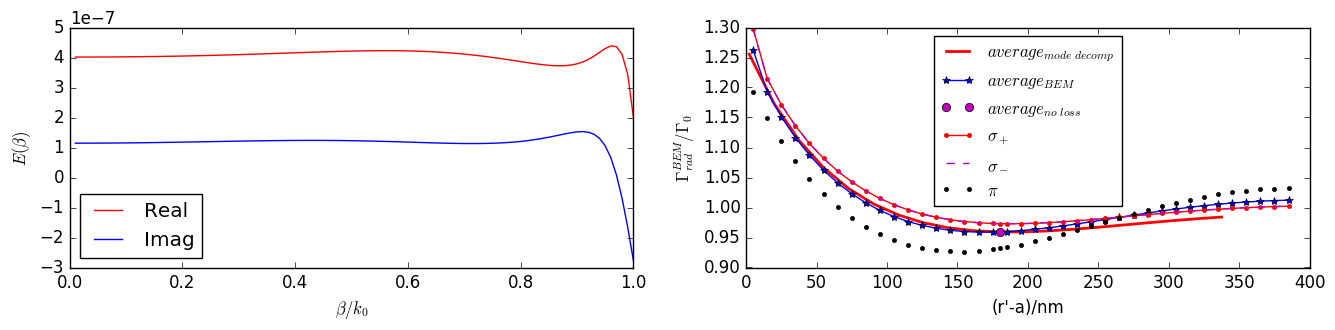

40-element Array{Float64,1}:
 1.26273 
 1.19281 
 1.15113 
 1.11658 
 1.08723 
 1.0622  
 1.04091 
 1.02288 
 1.00773 
 0.995152
 0.984854
 0.976597
 0.970163
 ⋮       
 0.987259
 0.990825
 0.99423 
 0.997424
 1.00037 
 1.00304 
 1.0054  
 1.00745 
 1.00916 
 1.01052 
 1.01155 
 1.01225 

In [11]:
# Load data for different dipole positions.
rp_BEM=[230,240,250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,405,410,420,430,440,450,460,470,480,490,500,510,520,530,540,550,560,570,580,590,600,610];
lenrp=length(rp_BEM);
lendr=146;
E_dipolex = readdlm("data/dipolex_E_N_1_lam_894_eps_2.1013_1e-05_a_225_x_405_y_0_q_0_1.45_146.dat", header=false);
k_vec=E_dipolex[:,2];
Ex_dx=zeros(Complex{Float64},lendr,lenrp); Ey_dx=zeros(Complex{Float64},lendr,lenrp); Ez_dx=zeros(Complex{Float64},lendr,lenrp);
Ex_dy=zeros(Complex{Float64},lendr,lenrp); Ey_dy=zeros(Complex{Float64},lendr,lenrp); Ez_dy=zeros(Complex{Float64},lendr,lenrp);
Ex_dz=zeros(Complex{Float64},lendr,lenrp); Ey_dz=zeros(Complex{Float64},lendr,lenrp); Ez_dz=zeros(Complex{Float64},lendr,lenrp);
for ii=1:lenrp
    E_dipolex = readdlm("data/dipolex_E_N_1_lam_894_eps_2.1013_0.001_a_225_x_$(rp_BEM[ii])_y_0_q_0_1.45_146.dat", header=false)
    Ex_dx[:,ii]=E_dipolex[:,5]+im*E_dipolex[:,6];
    Ey_dx[:,ii]=E_dipolex[:,7]+im*E_dipolex[:,8];
    Ez_dx[:,ii]=E_dipolex[:,9]+im*E_dipolex[:,10];
    
    E_dipoley = readdlm("data/dipoley_E_N_1_lam_894_eps_2.1013_0.001_a_225_x_$(rp_BEM[ii])_y_0_q_0_1.45_146.dat", header=false)
    Ex_dy[:,ii]=E_dipoley[:,5]+im*E_dipoley[:,6];
    Ey_dy[:,ii]=E_dipoley[:,7]+im*E_dipoley[:,8];
    Ez_dy[:,ii]=E_dipoley[:,9]+im*E_dipoley[:,10];
    
    E_dipolez = readdlm("data/dipolez_E_N_1_lam_894_eps_2.1013_0.001_a_225_x_$(rp_BEM[ii])_y_0_q_0_1.45_146.dat", header=false)
    Ex_dz[:,ii]=E_dipolez[:,5]+im*E_dipolez[:,6];
    Ey_dz[:,ii]=E_dipolez[:,7]+im*E_dipolez[:,8];
    Ez_dz[:,ii]=E_dipolez[:,9]+im*E_dipolez[:,10];
end
# Calculate the diagonal elements of the Green's function tensor from the radiation mode contribution.
c=2.99792458e8;
au=1.72e7; # This is the atomic unit in the CGS-units: $q/a_0^2$ statvolts/cm. In SI units, it becomes $e/(4π\varepsilon_0a_0^2)$ = 5.2e11 V/m.
lambda0=0.895e-6;
ω=2.*pi*c/lambda0;
GFT_rad_ind=zeros(Complex{Float64},3,3,lenrp);
Gxx_rad_ind=zeros(Complex{Float64},lenrp);
Gxy_rad_ind=zeros(Complex{Float64},lenrp);
Gxz_rad_ind=zeros(Complex{Float64},lenrp);
Gyx_rad_ind=zeros(Complex{Float64},lenrp);
Gyy_rad_ind=zeros(Complex{Float64},lenrp);
Gyz_rad_ind=zeros(Complex{Float64},lenrp);
Gzx_rad_ind=zeros(Complex{Float64},lenrp);
Gzy_rad_ind=zeros(Complex{Float64},lenrp);
Gzz_rad_ind=zeros(Complex{Float64},lenrp);
G0=Inf + 2.0/3.*(ω/c)^3*im;
gamma_rad_BEM_rp_average=zeros(lenrp);
gamma_rad_BEM_rp_sigmap=zeros(lenrp);
gamma_rad_BEM_rp_sigmam=zeros(lenrp);
gamma_rad_BEM_rp_pi=zeros(lenrp);
# Define the unitary dipole orientation vector.
e_dipole_sigmap=[-1.;-1.0*im;0]/sqrt(2);
e_dipole_sigmam=[1.; -1.0*im;0]/sqrt(2);
e_dipole_pi=[0.; 0.; 1.];
using NumericalIntegration
for ii=1:lenrp
    Gxx_rad_ind[ii]=integrate(k_vec[1:breakpoint],Ex_dx[1:breakpoint,ii],Trapezoidal())*(ω/c)^3/pi^2*au*4.0/3.;#G0+
    Gyy_rad_ind[ii]=integrate(k_vec[1:breakpoint],Ey_dy[1:breakpoint,ii],Trapezoidal())*(ω/c)^3/pi^2*au*4.0/3.;#G0+
    Gzz_rad_ind[ii]=integrate(k_vec[1:breakpoint],Ez_dz[1:breakpoint,ii],Trapezoidal())*(ω/c)^3/pi^2*au*4.0/3.;#G0+
    Gyx_rad_ind[ii]=integrate(k_vec[1:breakpoint],Ey_dx[1:breakpoint,ii],Trapezoidal())*(ω/c)^3/pi^2*au*4.0/3.;
    Gzx_rad_ind[ii]=integrate(k_vec[1:breakpoint],Ez_dx[1:breakpoint,ii],Trapezoidal())*(ω/c)^3/pi^2*au*4.0/3.;
    Gxy_rad_ind[ii]=integrate(k_vec[1:breakpoint],Ex_dy[1:breakpoint,ii],Trapezoidal())*(ω/c)^3/pi^2*au*4.0/3.;
    Gzy_rad_ind[ii]=integrate(k_vec[1:breakpoint],Ez_dy[1:breakpoint,ii],Trapezoidal())*(ω/c)^3/pi^2*au*4.0/3.;
    Gxz_rad_ind[ii]=integrate(k_vec[1:breakpoint],Ex_dz[1:breakpoint,ii],Trapezoidal())*(ω/c)^3/pi^2*au*4.0/3.;
    Gyz_rad_ind[ii]=integrate(k_vec[1:breakpoint],Ey_dz[1:breakpoint,ii],Trapezoidal())*(ω/c)^3/pi^2*au*4.0/3.;
    GFT_rad_ind[:,:,ii]=[Gxx_rad_ind[ii] Gxy_rad_ind[ii] Gxz_rad_ind[ii];
        Gyx_rad_ind[ii] Gyy_rad_ind[ii] Gzy_rad_ind[ii];
        Gzx_rad_ind[ii] Gzy_rad_ind[ii] Gzz_rad_ind[ii]];
end

# Calculate the relative averaged decay rate at the given dipole located at x=405nm and y=0.
gamma0=imag(G0);
for ii =1:lenrp
    gamma_rad_BEM_rp_average[ii]=1+trace(imag(GFT_rad_ind[:,:,ii]))/gamma0/3.;
    gamma_rad_BEM_rp_sigmap[ii]=1+real((e_dipole_sigmap'*imag(GFT_rad_ind[:,:,ii])*e_dipole_sigmap)/gamma0)[1];
    gamma_rad_BEM_rp_sigmam[ii]=1+real((e_dipole_sigmam'*imag(GFT_rad_ind[:,:,ii])*e_dipole_sigmam)/gamma0)[1];
    gamma_rad_BEM_rp_pi[ii]=1+real((e_dipole_pi'*imag(GFT_rad_ind[:,:,ii])*e_dipole_pi)/gamma0)[1];
end

# Recalculate the diagonal GFT elements with a dipole placed at r'=405nm from the fiber axis with lower imaginary part of epsilon.
E_dipolex = readdlm(join(["data/dipolex_E_N_1_lam_894_eps_2.1013_1e-05_a_225_x_","405","_y_0_q_0_1.45_146.dat"]), header=false)
Ex_dx_r0=E_dipolex[:,5]+im*E_dipolex[:,6];
Ey_dx_r0=E_dipolex[:,7]+im*E_dipolex[:,8];
Ez_dx_r0=E_dipolex[:,9]+im*E_dipolex[:,10];
E_dipoley = readdlm(join(["data/dipoley_E_N_1_lam_894_eps_2.1013_1e-05_a_225_x_","405","_y_0_q_0_1.45_146.dat"]), header=false)
Ex_dy_r0=E_dipoley[:,5]+im*E_dipoley[:,6];
Ey_dy_r0=E_dipoley[:,7]+im*E_dipoley[:,8];
Ez_dy_r0=E_dipoley[:,9]+im*E_dipoley[:,10];
E_dipolez = readdlm(join(["data/dipolez_E_N_1_lam_894_eps_2.1013_1e-05_a_225_x_","405","_y_0_q_0_1.45_146.dat"]), header=false)
Ex_dz_r0=E_dipolez[:,5]+im*E_dipolez[:,6];
Ey_dz_r0=E_dipolez[:,7]+im*E_dipolez[:,8];
Ez_dz_r0=E_dipolez[:,9]+im*E_dipolez[:,10];
Gxx_rad_r0=integrate(k_vec[1:breakpoint],Ex_dx_r0[1:breakpoint],Trapezoidal())*(ω/c)^3/pi^2*au*4./3.;
Gyy_rad_r0=integrate(k_vec[1:breakpoint],Ey_dy_r0[1:breakpoint],Trapezoidal())*(ω/c)^3/pi^2*au*4./3.;
Gzz_rad_r0=integrate(k_vec[1:breakpoint],Ez_dz_r0[1:breakpoint],Trapezoidal())*(ω/c)^3/pi^2*au*4./3.;
gamma_rad_BEM_r0=imag(Gxx_rad_r0+Gyy_rad_r0+Gzz_rad_r0)/3./gamma0;

# Plot out gamma_rad as a function of dipole position.
figure(figsize=(16,3));
subplot(1,2,1)
plot((1:breakpoint)/100.,real(Ex_dx[1:breakpoint,4]),"r-")
plot((1:breakpoint)/100.,imag(Ex_dx[1:breakpoint,4]),"b-")
ylabel(L"E(\beta)")
xlabel(L"\beta/k_0")
legend(["Real","Imag"],loc="lower left")

subplot(1,2,2)
a=225.;
plot(rp0_test[1,:]/1.e-9-a, 1+sum(gamma_rad,2), "r-", linewidth=2.0)
plot(rp_BEM-a,real(gamma_rad_BEM_rp_average),"b*-")
plot(405-a,real(gamma_rad_BEM_r0)+1.,"mo");
plot(rp_BEM-a,gamma_rad_BEM_rp_sigmap,"r.-");
plot(rp_BEM-a,gamma_rad_BEM_rp_sigmam,"m--");
plot(rp_BEM-a,gamma_rad_BEM_rp_pi,"k.")
xlabel("(r'-a)/nm")
ylabel(L"\Gamma_{rad}^{BEM}/\Gamma_0")
#ylim([0,1.2])
legend([L"average_{mode\,\,decomp}",L"average_{BEM}",L"average_{no\,\,loss}",L"\sigma_+",L"\sigma_-",L"\pi"],loc="upper center",fontsize=12);
#legend([L"average_{BEM}",L"average_{no\,\,loss}",L"\sigma_+",L"\sigma_-",L"\pi"],loc="upper center",fontsize=12);
gamma_rad_BEM_rp_average

On the plots above, the left shows the real and imaginary parts of the induced field component $E_x(r')$ when an $x$-polarized dipole was placed at $r'=405$nm away from the fiber axis. Results are calculated from BEM and are not normalized properly. When the wave number $k\approx k_0=\omega/c$, the values are changing dramatically, despite of a small givin loss to the material. 

The plot on the right-hand-side is the modified decay rates from the non-guided modes calculated in different methods and scenarios. 
The red solid line (using the verified "exact" mode decomposition method) and the blue stars (using the BEM approach) are the averaged decay rates from the non-guided mode contribution part given as
$$\begin{align}
\frac{\Gamma_{rad}}{\Gamma_0} &= 1+ \frac{\sum_{i=x,y,z}\mathrm{Im}\left[\mathbf{e}_i^*\cdot \mathbf{G}_{ind,rad}(\mathbf{r}',\mathbf{r}')\cdot \mathbf{e}_i\right]}{\sum_{i=x,y,z} \mathrm{Im}\left[\mathbf{e}_i^*\cdot \mathbf{G}_0(\mathbf{r}',\mathbf{r}')\cdot \mathbf{e}_i\right]}\\
&=1+ \frac{\sum_{i=x,y,z}\mathrm{Im}\left[\mathbf{e}_i^*\cdot \mathbf{G}_{ind,rad}(\mathbf{r}',\mathbf{r}')\cdot \mathbf{e}_i\right]}{3\mathrm{Im}\left[G_0(\mathbf{r}',\mathbf{r}')\right]}\\
&= 1+ \frac{\mathrm{Tr}\left\{\mathrm{Im}\left[ \mathbf{G}_{ind,rad}(\mathbf{r}',\mathbf{r}')\right]\right\}}{3\mathrm{Im}\left[G_0(\mathbf{r}',\mathbf{r}')\right]}
\end{align}$$
where $\mathbf{G}_0=G_0\mathbb{1}$ with $G_0(\mathbf{r}',\mathbf{r}';\omega)=\frac{2}{3}k_0^3$ is the Green's function in vacuum with $k_0=\frac{\omega}{c}$; and the radiation mode contribution of the induced Green's function tensor in presence of the nanofiber is 
$$ G_{ind,rad}^{ij}(\mathbf{r}',\mathbf{r}')=\frac{2k_0^2*a.u.}{3\pi^2}\int_{-k_0}^{k_0} d\beta E_j^i(\mathbf{r}')=\frac{4k_0^2*a.u.}{3\pi^2}\int_{0}^{k_0} d\beta E_j^i(\mathbf{r}')$$ with $E_j^i(\mathbf{r}')$ representing the $i$ electric field component with an atomic unit dipole polarized along $j$ direction ($i,j=1,y,z$).
Since the the BEM program uses atomic units and CGS-unit system, the prefactor in the formulas above, $a.u.=\frac{q}{a_0^2}=1.72\times 10^7$statvolts/cm, comes from the atomic unit transformation.
Compared to the previous averaged LDOS calculation (red curve), the averaged decay rate (dots) calculated based on the local feild componets with dipoles orientated along three basis directions using the BEM program matches our exact solution pretty well.
The small mismatch when the dipole position becomes far from the fiber surface may be due to the fact that our "exact" decay rate for comparison was actually truncated up to $10$-th order of the non-guided eigen modes of the nanofiber which yields some error for the final result.
From what we have calculated earlier for LDOS, the induced non-guided mode contribution part to the decay rate could be negative at some dipole positions which is correctly reflected at the series of numbers as the last output of the calculation above. 

From the second plot, we also show the non-guided mode induced decay rates that can be coupled to the $\sigma_\pm$ and $\pi$ dipole transitions. 
As you can see, when the atoms are placed around $200$nm from the nanofiber surface, different dipole transitions don't make a noticeable difference which is no longer true for the square waveguide case as shown in another simulation notebook.
In details, we calculate the polarization-dependent decay rates from the non-guided mode contributions by 
$$\begin{align}
\frac{\Gamma_{rad}}{\Gamma_0} &= 1+ \frac{\mathrm{Im}\left[\mathbf{e}_q^*\cdot \mathbf{G}_{ind,rad}(\mathbf{r}',\mathbf{r}')\cdot \mathbf{e}_q\right]}{ \mathrm{Im}\left[\mathbf{e}_q^*\cdot \mathbf{G}_0(\mathbf{r}',\mathbf{r}')\cdot \mathbf{e}_q\right]}
=1+ \frac{\mathrm{Im}\left[\mathbf{e}_q^*\cdot \mathbf{G}_{ind,rad}(\mathbf{r}',\mathbf{r}')\cdot \mathbf{e}_q\right]}{\mathrm{Im}\left[G_0(\mathbf{r}',\mathbf{r}')\right]},
\end{align}$$
where the three orthogonal dipole transition bases
$$\begin{align}
\mathbf{e}_\pm &=\mp \frac{\mathbf{e}_{\tilde{x}}\pm i\mathbf{e}_{\tilde{y}}}{\sqrt{2}}\\
\mathbf{e}_0 &=\mathbf{e}_{\tilde{z}}
\end{align}$$
correspond to the $\sigma_\pm$ and $\pi$ transitions of the atoms.
These basis vectors are quantization-axis dependent, but in our calculation above, we assume the $z$-axis or the waveguide axis is the quantization axis, and hence $\mathbf{e}_{\tilde{x}}=\mathbf{e}_x$, $\mathbf{e}_{\tilde{y}}=\mathbf{e}_y$ and $\mathbf{e}_{\tilde{z}}=\mathbf{e}_z$. 

In [12]:
# Export some variables to a MAT file.
#using HDF5,JLD
#h5open("data/Julia_nanofiber_GFT_decayrates_rad.h5", "w") do h5file
#    g=g_create(h5file, "nanofiber")
#    write(h5file, "nanofiber/rp_BEM", rp_BEM)#, "GFT_rad_ind",GFT_rad_ind)#,"omega",ω,"gamma0",gamma0,"e_dipole_sigmap",e_dipole_sigmap, "e_dipole_sigmam",e_dipole_sigmam,"e_dipole_pi",e_dipole_pi,"gamma_rad_BEM_rp_average",gamma_rad_BEM_rp_average,"gamma_rad_BEM_rp_sigmap",gamma_rad_BEM_rp_sigmap,"gamma_rad_BEM_rp_sigmam",gamma_rad_BEM_rp_sigmam,"gamma_rad_BEM_rp_pi",gamma_rad_BEM_rp_pi,"a",a)
#    write(h5file,"nanofiber/GFT_rad_ind",GFT_rad_ind)
#end
#save("data/Julia_nanofiber_GFT_decayrates_rad.jld","rp_BEM",rp_BEM,"imGFT_rad_ind",imag(GFT_rad_ind),"omega0",ω)
using MAT
matopen("data/Julia_nanofiber_GFT_decayrates_rad_D1.mat", "w") do matfile
    write(matfile,"omega0",ω)
    write(matfile,"rp_BEM",collect(rp_BEM))
    write(matfile,"gamma0",gamma0)
    write(matfile,"e_dipole_sigmap",e_dipole_sigmap)
    write(matfile,"e_dipole_sigmam",e_dipole_sigmam)
    write(matfile,"e_dipole_pi",e_dipole_pi)
    write(matfile,"gamma_rad_BEM_rp_average",gamma_rad_BEM_rp_average)
    write(matfile,"gamma_rad_BEM_rp_sigmap",gamma_rad_BEM_rp_sigmap)
    write(matfile,"gamma_rad_BEM_rp_sigmam",gamma_rad_BEM_rp_sigmam)
    write(matfile,"gamma_rad_BEM_rp_pi",gamma_rad_BEM_rp_pi)
    write(matfile,"a",a)
    write(matfile,"GFT_rad_rp",GFT_rad_ind)
    write(matfile,"Gxx_rad_rp",Gxx_rad_ind)
    write(matfile,"Gxy_rad_rp",Gxy_rad_ind)
    write(matfile,"Gxz_rad_rp",Gxz_rad_ind)
    write(matfile,"Gyx_rad_rp",Gyx_rad_ind)
    write(matfile,"Gyy_rad_rp",Gyy_rad_ind)
    write(matfile,"Gyz_rad_rp",Gyz_rad_ind)
    write(matfile,"Gzx_rad_rp",Gzx_rad_ind)
    write(matfile,"Gzy_rad_rp",Gzy_rad_ind)
    write(matfile,"Gzz_rad_rp",Gzz_rad_ind)
end